In [1]:
from datasets import load_dataset

train_ds = load_dataset("imagefolder", data_dir="audio_transformer/data/train", split="train")


# split up training into training + validation
splits = train_ds.train_test_split(test_size=0.3)
train_val_ds = splits['train']
test_ds = splits['test']

splits = train_val_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']


print(len(train_ds),len(test_ds),len(val_ds))

Resolving data files:   0%|          | 0/8733 [00:00<?, ?it/s]

Using custom data configuration default-056bb73702904399
Reusing dataset image_folder (/home/ubuntu/.cache/huggingface/datasets/image_folder/default-056bb73702904399/0.0.0/48efdc62d40223daee675ca093d163bcb6cb0b7d7f93eb25aebf5edca72dc597)


5500 2620 612


In [2]:
train_ds

Dataset({
    features: ['image', 'classID', 'class'],
    num_rows: 5500
})

In [3]:
import json

with open('audio_transformer/data/label2id.json') as f:
    label2id = json.load(f)

with open('audio_transformer/data/id2label.json') as f:
    id2label = json.load(f)

id2label = {int(key):value for key,value in id2label.items()}
id2label

{0: 'air_conditioner',
 1: 'car_horn',
 2: 'children_playing',
 3: 'dog_bark',
 4: 'drilling',
 5: 'engine_idling',
 6: 'gun_shot',
 7: 'jackhammer',
 8: 'siren',
 9: 'street_music'}

In [4]:
from transformers import AutoFeatureExtractor, SwinForImageClassification

feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
# model = SwinForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224")


In [5]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [6]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [7]:
train_ds[:2]

{'image': [<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=496x369 at 0x7F8F2C705CF8>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=496x369 at 0x7F8F2C7059B0>],
 'classID': [0, 3],
 'class': ['air_conditioner', 'dog_bark'],
 'pixel_values': [tensor([[[-1.3987, -1.4158, -1.5357,  ..., -1.5357, -1.5357, -1.5357],
           [-1.3815, -1.3815, -1.4500,  ..., -1.5699, -1.5699, -1.5699],
           [-1.3473, -1.3473, -1.3473,  ..., -1.6042, -1.6213, -1.6213],
           ...,
           [ 2.1119,  2.1119,  2.1119,  ...,  2.0263,  1.9578,  1.9407],
           [ 2.1462,  2.1462,  2.1804,  ...,  1.9407,  1.9235,  1.9235],
           [ 2.1462,  2.1462,  2.1804,  ...,  1.9407,  1.9235,  1.9235]],
  
          [[-1.7381, -1.7381, -1.7381,  ..., -1.7381, -1.7381, -1.7381],
           [-1.7381, -1.7381, -1.7381,  ..., -1.7381, -1.7381, -1.7381],
           [-1.7381, -1.7381, -1.7381,  ..., -1.7381, -1.7381, -1.7381],
           ...,
           [-0.0224, -0.0224, -0.0224,  ..., -0.25

In [8]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["classID"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [9]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [10]:
from transformers import SwinForImageClassification

model = SwinForImageClassification.from_pretrained('microsoft/swin-tiny-patch4-window7-224',
                                                  num_labels=10,
                                                  id2label=id2label,
                                                  label2id=label2id,
                                                  ignore_mismatched_sizes=True)

/home/ubuntu/anaconda3/envs/aws_neuron_pytorch_p36/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"test-cifar-10",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [12]:
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [13]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

In [14]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir logs/

In [15]:
trainer.train()

/home/ubuntu/anaconda3/envs/aws_neuron_pytorch_p36/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5500
  Num Epochs = 5
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 2750


Epoch,Training Loss,Validation Loss,Accuracy
1,1.223700,0.772136,0.743464
2,0.780700,0.499137,0.826797
3,0.636600,0.362285,0.892157
4,0.560900,0.360236,0.869281
5,0.477300,0.329973,0.892157


***** Running Evaluation *****
  Num examples = 612
  Batch size = 4
Saving model checkpoint to test-cifar-10/checkpoint-550
Configuration saved in test-cifar-10/checkpoint-550/config.json
Model weights saved in test-cifar-10/checkpoint-550/pytorch_model.bin
Feature extractor saved in test-cifar-10/checkpoint-550/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 612
  Batch size = 4
Saving model checkpoint to test-cifar-10/checkpoint-1100
Configuration saved in test-cifar-10/checkpoint-1100/config.json
Model weights saved in test-cifar-10/checkpoint-1100/pytorch_model.bin
Feature extractor saved in test-cifar-10/checkpoint-1100/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 612
  Batch size = 4
Saving model checkpoint to test-cifar-10/checkpoint-1650
Configuration saved in test-cifar-10/checkpoint-1650/config.json
Model weights saved in test-cifar-10/checkpoint-1650/pytorch_model.bin
Feature extractor saved in test-cifar-10/checkpoint-16

TrainOutput(global_step=2750, training_loss=0.7122988641912287, metrics={'train_runtime': 2162.6639, 'train_samples_per_second': 12.716, 'train_steps_per_second': 1.272, 'total_flos': 6.8369249507328e+17, 'train_loss': 0.7122988641912287, 'epoch': 5.0})

In [16]:
outputs = trainer.predict(test_ds)

***** Running Prediction *****
  Num examples = 2620
  Batch size = 4


In [17]:
print(outputs.metrics)

{'test_loss': 0.37027508020401, 'test_accuracy': 0.8729007633587786, 'test_runtime': 82.8466, 'test_samples_per_second': 31.625, 'test_steps_per_second': 7.906}


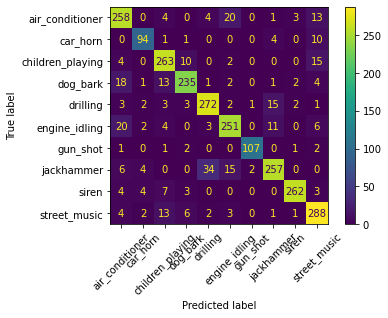

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = id2label.values()
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [19]:
model.save_pretrained("/home/ubuntu/models/AudioSWIN")

Configuration saved in /home/ubuntu/models/AudioSWIN/config.json
Model weights saved in /home/ubuntu/models/AudioSWIN/pytorch_model.bin
